In [22]:
import pandas as pd
import numpy as np
from arch import arch_model
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

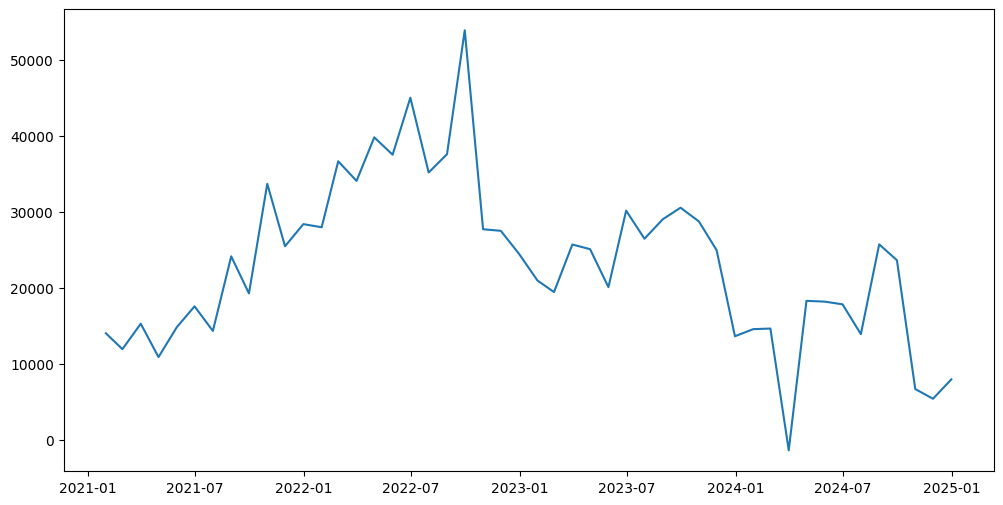

In [ ]:
# read a file from the parent directory
y = pd.read_csv('../processed_data/historical_data.csv', parse_dates=["Date"])[["Date", "Imbalance"]]
y.set_index("Date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Imbalance')
plt.plot()

The series is stationary. So we take first difference.
ADF Statistic: -1.7115375637745192
p-value: 0.4251779952789853


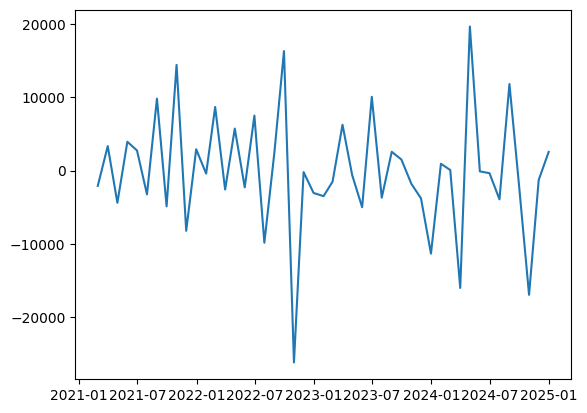

In [34]:
# Stationarity Test
adf_test = adfuller(y)

if( adf_test[1] > 0.05):
    print("The series is stationary. So we take first difference.")
    y = y.diff().dropna()
else:
    print("The series is non-stationary. No need to take first difference")

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

plt.plot(y)

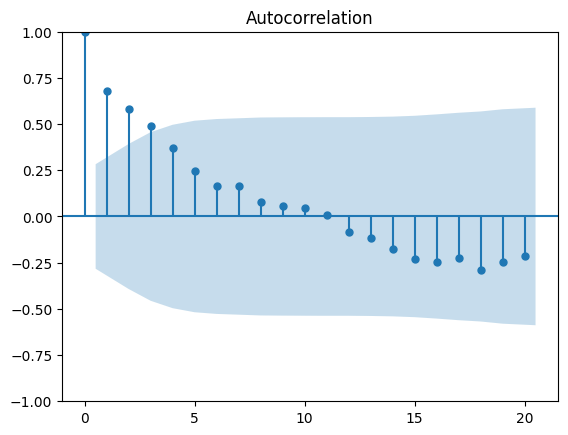

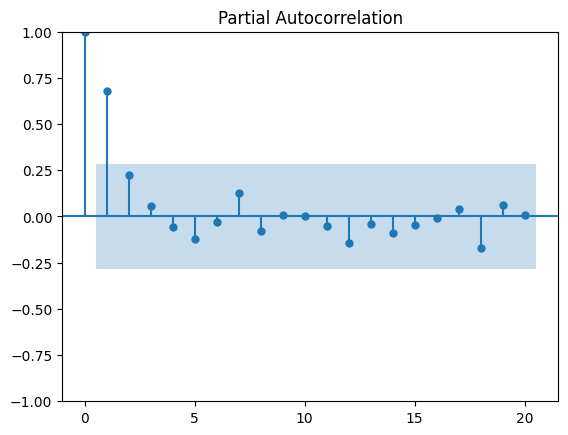

In [26]:
plot_acf(y, lags=20)
plot_pacf(y, lags=20)

plt.show()

c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


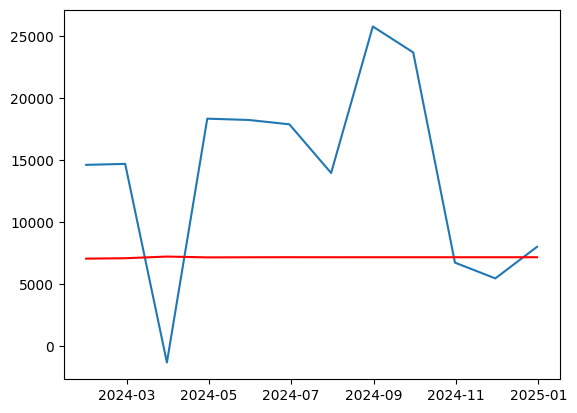

In [30]:
n_test = 12
train, test = y[:-n_test], y[-n_test:]

model = ARIMA(y, order=(2, 1, 0))
model_fit = model.fit()

yhat = model_fit.get_forecast(steps = n_test)

plt.plot(test.index, test, label='Imbalance')
plt.plot(test.index, yhat.predicted_mean, label='Predicted Imbalance', color='red')

In [ ]:
model = arch_model(y.diff().dropna(), vol='Garch', p=10, q=10, mean='zero')  # mean = 'Zero' assumes you differenced it
model_fit = model.fit(disp="off")

plt.plot(yhat.variance.values[-1, :])
plt.plot(test.values**2, color='red')
plt.show()